# Семантическая Сегментация. Часть 3.

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import os
import skimage.io as io
import numpy as np

import tensorflow as tf

## Загрузка датасета COCO и COCO API

In [3]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2022-08-11 10:34:03--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.131.97
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.131.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  12.7MB/s    in 24m 45s 

2022-08-11 10:58:48 (12.4 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-08-11 10:58:49--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.41.209
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.41.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  12.5MB/s    in 64s     

2022-08-11 10:59:54 (12.1 MB/s) - ‘v

## Подготовка COCO API

In [4]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=17.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [8]:
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
TRAIN_EPOCHS = 1
INPUT_SIZE = 384

In [9]:
train_ds = COCO_dataset_train.train_dataset(TRAIN_BATCH_SIZE, TRAIN_EPOCHS, INPUT_SIZE)
val_ds = COCO_dataset_val.val_dataset(VAL_BATCH_SIZE, INPUT_SIZE)

In [10]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(32, 384, 384, None), dtype=tf.float32, name=None), TensorSpec(shape=(32, 384, 384, None), dtype=tf.float32, name=None))>

In [11]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out
    
model = ASPPNet()

In [12]:
model.build(input_shape=(32, 384, 384, 3))

In [13]:
model.summary()

Model: "aspp_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  147584    
                                                                 
 conv2d_4 (Conv2D)           multiple                  295168    
                                                                 
 conv2d_5 (Conv2D)           multiple                  590080    
                                                                 
 conv2d_6 (Conv2D)           multiple                  118

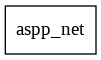

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=5, 
                    validation_data=val_ds)

Epoch 1/5
2003/2003 [==============================] - 4067s 2s/step - loss: 0.3559 - accuracy: 0.8466 - val_loss: 0.2736 - val_accuracy: 0.8763
Epoch 2/5
2003/2003 [==============================] - 4022s 2s/step - loss: 0.2398 - accuracy: 0.8942 - val_loss: 0.2569 - val_accuracy: 0.8923
Epoch 3/5
1669/2003 [=======================>......] - ETA: 10:55 - loss: 0.2090 - accuracy: 0.9105